In [1]:
!pip install accelerate==0.21.0
!pip install peft==0.4.0
!pip install bitsandbytes==0.40.2
!pip install transformers==4.31.0
!pip install trl==0.4.7
!pip install scipy
!pip install tensorboard


[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
!pip install pandas numpy scikit-learn tensorflow optuna matplotlib seaborn imbalanced-learn evaluate -q --root-user-action=ignore


[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [3]:
!nvidia-smi

Mon Jun  9 05:10:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.77                 Driver Version: 565.77         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5000               On  |   00000000:04:00.0 Off |                  Off |
|  0%   29C    P8             20W /  230W |    2004MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
!pip install "numpy<2.0" --root-user-action=ignore


[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [5]:
import warnings
import os
import shutil
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import LabelEncoder

from datasets import Dataset, DatasetDict, load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)

from peft import LoraConfig, TaskType, get_peft_model  # For LoRA fine-tuning
import evaluate  # For additional evaluation metrics
import optuna  # For hyperparameter optimization
from transformers import BitsAndBytesConfig  # Helps with quantization
from tqdm import tqdm  # Progress bar for training and evaluation
from transformers import EarlyStoppingCallback
import pickle  # Save model artifacts



# Set CUDA_LAUNCH_BLOCKING for better error messages
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Ignore specific warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="transformers")

2025-06-09 05:10:15.229800: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-09 05:10:15.234376: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-09 05:10:15.247558: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749445815.268849   17717 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749445815.275440   17717 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749445815.290998   17717 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [6]:
file_path = "/workspace/synthetic_mobile_money_transaction_dataset (2).csv"
df = pd.read_csv(file_path)

In [7]:
from sklearn.model_selection import train_test_split

# Split the dataset into features (X) and labels (y)
X = df.drop('isFraud', axis=1)   # Full feature set
y = df['isFraud']                # Full target labels

# Split into training (80%), validation (10%), and test sets (10%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Print the sizes
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")


Training set size: 3380766
Validation set size: 422596
Test set size: 422596


In [8]:
def convert_to_sentence(row):
    # Access 'isFraud' from the original DataFrame 'df' using the row index
    isFraud_value = df.loc[row.name, 'isFraud']


    if row['transactionType'] == 'transfer':
        sentence = (f"Transaction Details (Step {row['step']}):\n"
                    f"- Transaction Type: '{row['transactionType']}'\n"
                    f"- Transaction Amount: ${row['amount']:.2f}\n"
                    f"- Initiator's Balance: From ${row['oldBalInitiator']:.2f} to ${row['newBalInitiator']:.2f}\n"
                    f"- Recipient's Balance: From ${row['oldBalRecipient']:.2f} to ${row['newBalRecipient']:.2f}\n"
                    f"- Please determine if this transfer is suspicious based on the balances and amount.")
    else:
        sentence = (f"Transaction Details (Step {row['step']}):\n"
                    f"- Transaction Type: '{row['transactionType']}'\n"
                    f"- Transaction Amount: ${row['amount']:.2f}\n"
                    f"- Initiator's Balance: From ${row['oldBalInitiator']:.2f} to ${row['newBalInitiator']:.2f}\n"
                    f"- Recipient's Balance: From ${row['oldBalRecipient']:.2f} to ${row['newBalRecipient']:.2f}\n"
                    f"- Based on this transaction, assess if it shows irregularities.")
    return sentence


In [9]:
# Apply the textualization function to the training, validation, and test sets
train_texts = X_train.apply(convert_to_sentence, axis=1)
val_texts = X_val.apply(convert_to_sentence, axis=1)
test_texts = X_test.apply(convert_to_sentence, axis=1)

In [10]:
!pip install bitsandbytes --root-user-action=ignore


[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [11]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# This will download the tokenizer and model files and cache them locally
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
model = AutoModelForCausalLM.from_pretrained("distilgpt2")



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [12]:
from transformers import GPT2Tokenizer

# Initialize the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("distilbert/distilgpt2")

# Set pad_token to eos_token
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id

# Tokenize the datasets
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)

In [13]:

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # Extract the input_ids and attention_mask for this index
        item = {
            "input_ids": torch.tensor(self.encodings["input_ids"][idx], dtype=torch.long),
            "attention_mask": torch.tensor(self.encodings["attention_mask"][idx], dtype=torch.long),
            "labels": torch.tensor(self.labels[idx], dtype=torch.float)  # 👈 Set dtype to float for BCEWithLogitsLoss
        }
        return item

    def __len__(self):
        return len(self.labels)

# Convert to dataset
train_dataset = CustomDataset(train_encodings, y_train.values)
val_dataset = CustomDataset(val_encodings, y_val.values)
test_dataset = CustomDataset(test_encodings, y_test.values)


In [14]:
from peft import get_peft_model, LoraConfig

# Configure LoRA
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["c_attn"],  # Valid for GPT-2-like models
    bias="none",
    task_type="SEQ_CLS"
)

# Load pre-trained DistilGPT-2 and apply LoRA
from transformers import GPT2ForSequenceClassification

model = GPT2ForSequenceClassification.from_pretrained("distilgpt2")

# Set the padding token for the model (this must match the tokenizer's padding token)
model.config.pad_token_id = model.config.eos_token_id

model = get_peft_model(model, lora_config)


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora.py:299: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [15]:
# 📦 Required Imports
import numpy as np
import torch
from sklearn.metrics import accuracy_score, roc_auc_score
from transformers import Trainer, TrainingArguments, TrainerCallback

# ✅ 1. Define compute_metrics function
def compute_metrics(pred):
    labels = pred.label_ids.astype(int)
    logits = torch.tensor(pred.predictions, dtype=torch.float32).squeeze()
    probs = torch.sigmoid(logits).numpy()
    preds = (probs >= 0.5).astype(int)

    acc = accuracy_score(labels, preds)
    auc = roc_auc_score(labels, probs)

    return {
        'accuracy': acc,
        'auc': auc
    }

# ✅ 2. Custom callback to log metrics
class LossLoggerCallback(TrainerCallback):
    def __init__(self):
        self.epoch_logs = []

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        epoch = int(state.epoch)
        for log in self.epoch_logs:
            if log["epoch"] == epoch:
                log["val_loss"] = metrics.get("eval_loss", float('nan'))
                log["accuracy"] = metrics.get("eval_accuracy", float('nan'))
                log["auc"] = metrics.get("eval_auc", float('nan'))

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and "loss" in logs and "epoch" in logs:
            epoch = int(logs["epoch"])
            if not any(log["epoch"] == epoch for log in self.epoch_logs):
                self.epoch_logs.append({
                    "epoch": epoch,
                    "train_loss": logs["loss"],
                    "val_loss": float('nan'),
                    "accuracy": float('nan'),
                    "auc": float('nan'),
                })

    def display(self):
        print(f"{'Epoch':<6}{'Training Loss':<15}{'Validation Loss':<18}{'Accuracy':<12}{'Auc'}")
        for log in self.epoch_logs:
            print(f"{log['epoch']:<6}{log['train_loss']:<15.6f}{log['val_loss']:<18.6f}{log['accuracy']:<12.6f}{log['auc']:.6f}")

# ✅ 3. Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    warmup_steps=100,
    weight_decay=0.01
)

# ✅ 4. Instantiate callback
loss_callback = LossLoggerCallback()

# ✅ 5. Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    callbacks=[loss_callback],
    compute_metrics=compute_metrics
)

# ✅ 6. Train and evaluate
train_output = trainer.train()
eval_output = trainer.evaluate()

# ✅ 7. Display metrics log per epoch
loss_callback.display()


Epoch,Training Loss,Validation Loss,Accuracy,Auc
1,0.010600,0.026358,0.545244,0.996117
2,0.025800,0.024906,0.922886,0.996045
3,0.022400,0.024826,0.930693,0.996166
4,0.039700,0.025425,0.901840,0.996142
5,0.000900,0.025978,0.897697,0.996118


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch Training Loss  Validation Loss   Accuracy    Auc
0     0.314100       nan               nan         nan
1     0.011200       0.026358          0.545244    0.996117
2     0.028700       0.024906          0.922886    0.996045
3     0.041900       0.024826          0.930693    0.996166
4     0.029300       0.025425          0.901840    0.996142
5     0.009100       0.024826          0.930693    0.996166


In [16]:
# Get predictions
predictions = trainer.predict(val_dataset)
logits = torch.tensor(predictions.predictions).squeeze()
probs = torch.sigmoid(logits).numpy()
preds = (probs >= 0.5).astype(int)
labels = predictions.label_ids

In [17]:
# 1️⃣ Classification Report
from sklearn.metrics import classification_report

print("\nClassification Report:\n")
print(classification_report(labels, preds, target_names=["Legitimate", "Fraud"]))


Classification Report:

              precision    recall  f1-score   support

  Legitimate       1.00      0.85      0.92    199284
       Fraud       0.88      1.00      0.94    223312

    accuracy                           0.93    422596
   macro avg       0.94      0.93      0.93    422596
weighted avg       0.94      0.93      0.93    422596



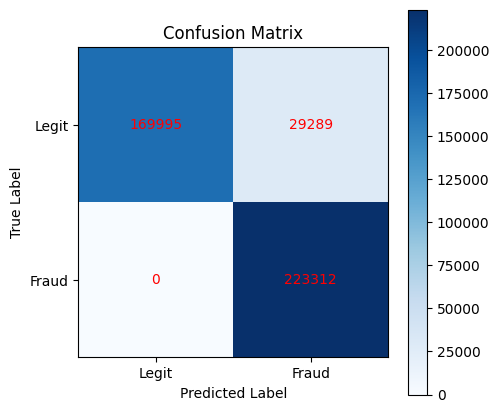

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 2️⃣ Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(5, 5))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0, 1], ["Legit", "Fraud"])
plt.yticks([0, 1], ["Legit", "Fraud"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.colorbar()
plt.show()

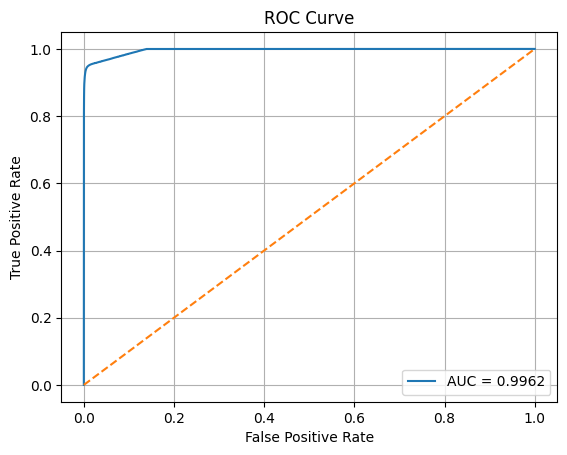

In [19]:

# 3️⃣ ROC Curve
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(labels, probs)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(labels, probs):.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

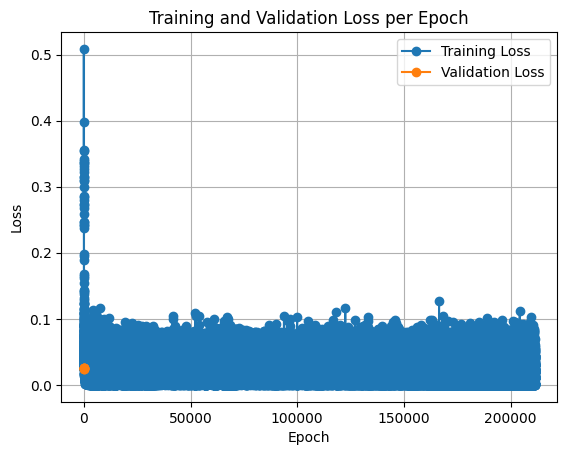

In [20]:
# Extract training and validation losses correctly
train_losses = [log['loss'] for log in trainer.state.log_history if 'loss' in log and 'epoch' in log]
eval_losses = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log and 'epoch' in log]

# Generate separate x-axis for each based on their actual lengths
train_epochs = list(range(1, len(train_losses) + 1))
eval_epochs = list(range(1, len(eval_losses) + 1))

# Plot losses
plt.figure()
plt.plot(train_epochs, train_losses, label="Training Loss", marker='o')
plt.plot(eval_epochs, eval_losses, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid()
plt.show()

In [21]:
# Save model
save_dir = "results/distilgpt2"
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

('results/distilgpt2/tokenizer_config.json',
 'results/distilgpt2/special_tokens_map.json',
 'results/distilgpt2/vocab.json',
 'results/distilgpt2/merges.txt',
 'results/distilgpt2/added_tokens.json')

In [23]:
# Install Required Libraries
!pip install shap transformers torch


[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [ ]:
import shap
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# 1. Load tokenizer and model
model_path = "results/distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()

# 2. Create a Hugging Face text classification pipeline
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

# 3. Wrap pipeline in SHAP Explainer
explainer = shap.Explainer(pipe)

# 4. Input must be a list of complete strings
sample_texts = [
    "A transfer of $39.03 was made by the initiator with a starting balance of $39.03, leaving them with $0.00. The recipient's balance increased from $55.94 to $94.98."
]

# 5. Compute SHAP values
shap_values = explainer(sample_texts)

# 6. Visualize (e.g., bar plot)
shap.plots.text(shap_values[0])